### Pydantic Example


In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz: str
    abc: str

In [17]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel, StrictStr


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(BaseModel):
    a: StrictStr

def node(state:OverallState):
    return {"a":"Hi I am Deepak"}

In [18]:
# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(node)  # node_1 is the first node
builder.add_edge(START, "node")  # Start the graph with node_1
builder.add_edge("node", END)  # End the graph after node_1
graph = builder.compile()

In [19]:
graph.invoke({'a': 'Hello'})

{'a': 'Hi I am Deepak'}

In [20]:
try:
    graph.invoke({"a":123}) # should be a string
except Exception as e:
    print("Exception was raised because a value is integer")

In [21]:
graph.invoke({'a':123})

{'a': 'Hi I am Deepak'}

### Multiple Nodes - Run time validation

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called(not when bad_node returns an update to the state which is in consistent with the schema).

In [22]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel

class OverallState(BaseModel):
    a:str

def bad_node(state:OverallState):
    return{
        'a':123 # Invalid
    }

def ok_node(state:OverallState):
    return {'a':'goodbye'}

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, 'bad_node')
builder.add_edge('bad_node', 'ok_node')
builder.add_edge('ok_node', END)
graph = builder.compile()

In [28]:
# Test the graph with a valid input
try:
    graph.invoke({'a':123.00})
except Excpetion as e:
    print("An exception was raised because bad_node sets 'a' to an integer.")
    print(e)

In [27]:
graph.invoke({'a':'Deepak'})

{'a': 'goodbye'}

### Prompt Chaining

Prompt chaining decomposes a task into sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and clearly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

In [30]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

llm = ChatGroq(model='llama3-70b-8192')
result = llm.invoke('Hello')
result


AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.074285714, 'prompt_time': 0.000128439, 'queue_time': 0.052475100999999996, 'total_time': 0.074414153}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run-3af366ae-a301-43b5-a113-f1b8a14926bf-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})

In [32]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [39]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}



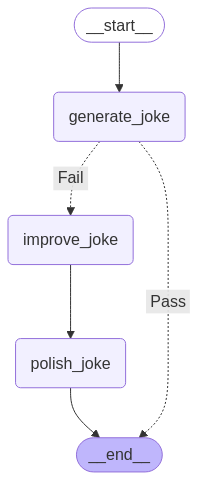

In [40]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [43]:
state = chain.invoke({"topic": "baby"})

In [44]:
state

{'topic': 'baby',
 'joke': 'Why did the baby\'s first word was "mama"?\n\nBecause it was the only word that came with a warranty!',
 'improved_joke': 'Here\'s a revised version with some added wordplay:\n\nWhy did the baby\'s first word have to be "mama"?\n\nBecause it was the only word that came with a mom-umental warranty, and the little one wanted to ensure they had a parent-al guarantee of love and care!',
 'final_joke': 'Here\'s a revised version with a surprising twist:\n\nWhy did the baby\'s first word have to be "mama"?\n\nBecause it was the only word that came with a mom-umental warranty, and the little one wanted to ensure they had a parent-al guarantee of love and care... but little did they know, the warranty was issued by a secret society of ninja moms, and the "care" clause included stealth training and a lifetime supply of ninja diapers!'}

In [46]:
state['improved_joke']

'Here\'s a revised version with some added wordplay:\n\nWhy did the baby\'s first word have to be "mama"?\n\nBecause it was the only word that came with a mom-umental warranty, and the little one wanted to ensure they had a parent-al guarantee of love and care!'

In [47]:
state['final_joke']

'Here\'s a revised version with a surprising twist:\n\nWhy did the baby\'s first word have to be "mama"?\n\nBecause it was the only word that came with a mom-umental warranty, and the little one wanted to ensure they had a parent-al guarantee of love and care... but little did they know, the warranty was issued by a secret society of ninja moms, and the "care" clause included stealth training and a lifetime supply of ninja diapers!'

### Parallelization

With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations:-

Sectioning: Breaking a task into independent subtask run in parallel.

Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Paralleleization is effective when the divided subtasks can be parrallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by the seperate LLM call, allowing focused attention on each specific aspect.

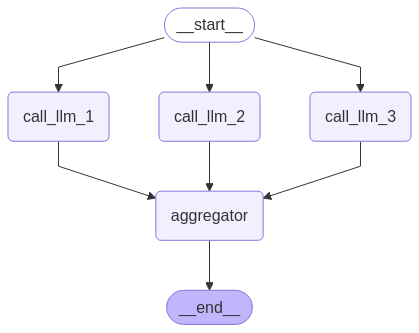

Here's a story, joke, and poem about cats!

STORY: 
**Whisker Tales**

In the sleepy town of Felinia, where sunbeams danced through the windows and catnip grew wild, a mystical realm thrived. Here, cats ruled supreme, their whims and fancies governing the world. A magical council, comprised of nine wise felines, governed the land, ensuring harmony and balance among all creatures.

Our tale begins with a curious, mischievous calico named Luna. Born with a spark of mischief in her eye, Luna loved to explore the hidden corners of Felinia. One day, while prowling through the Whispering Walls, a labyrinthine alleyway lined with ancient stones, she stumbled upon an enchanted artifact – the Golden Whisker of Fate.

Legend whispered that this whisker, forged from the essence of the first cat, held the power to shape destiny. Luna, intrigued by the whispers, decided to investigate further. As she grasped the whisker, a sudden, blinding flash illuminated the alley. When the light faded, Luna dis

In [50]:
# Graph state
class State(TypedDict):
    topic:str
    joke:str
    story:str
    poem:str
    combined_output:str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state:State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a astory about {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: State):
    """Combine the joke, story and poem into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY: \n{state['story']}\n\n"
    combined += f"JOKE: \n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

### Routing

Routing classifies an input and directs it to a specialized followup task. This workflow allows for seperation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

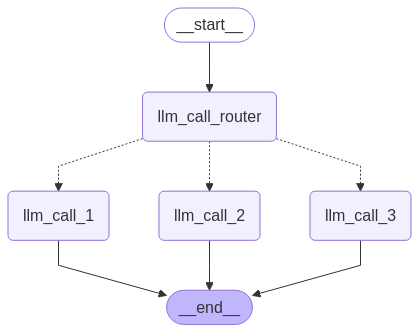

In [59]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structure output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(None, description="The next step in the routing process")

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

# State
class State(TypedDict):
    input: str
    decision: str
    output: str

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state:State):
    # Return the node name you want to visit next
    if state['decision'] == "story":
        return 'llm_call_1'
    elif state['decision'] == 'joke':
        return 'llm_call_2'
    elif state['decision'] == 'poem':
        return "llm_call_3"

# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder. add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    { # Name returned by route_decision : Name of the next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",        
    },
)

router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))



In [60]:
# Invoke
state = router_workflow.invoke({"input": "Write me a story about cats"})
print(state["output"])

Once upon a time, in a small village nestled in the rolling hills of the countryside, there lived a community of cats. These cats were no ordinary felines, for they possessed a deep understanding of the mystical forces that governed the universe.

At the heart of the village stood an ancient, gnarled tree, its branches twisted and tangled in a way that seemed almost deliberate. This tree was the sacred center of the cats' world, for it was said that the ancient ones had planted it with their own paws, imbuing it with their collective wisdom and magic.

The leader of the cats was a majestic creature named Astra. Her fur was as white as the stars on a clear night, and her eyes shone like sapphires in the sunlight. Astra possessed the greatest understanding of the mystical forces, and it was she who communicated with the ancient ones, seeking guidance and wisdom for her people.

One day, a young cat named Lyra approached Astra with a curious question. "Why do we, as cats, possess such ext

In [61]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

LLM call 2 is called
Why did the cat join a band?

Because it wanted to be the purr-cussionist!


In [62]:
# Invoke
state = router_workflow.invoke({"input": "Write me a poem about cats"})
print(state["output"])

Whiskers twitch, ears so fine,
Moonbeams dance, eyes divine.
Furry shadows, silent creep,
Midnight whispers, velvet sleep.

Claws that whisper, eyes that gleam,
Purrs that rumble, hearts that beam.
Tail that swishes, slow, and low,
Feline mystique, secrets to know.

Whispering winds, starry nights,
Moonlit whispers, feline delights.
Shadows dance, eyes aglow,
Furry magic, hearts that know.

Purrs that rumble, eyes that shine,
Whiskers twitch, hearts that entwine.
Furry companions, loyal friend,
Feline magic, till the end.


### Orchestrator-Worker

In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can't predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it's topographically similar, the key difference from parallelization is its flexibility--subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

In [63]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create nodes and send each one a specific input.
Each worker has its own state, and all worker outputs are written to a shared state key that is accessibe to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into final output. As you can see below, we iterate over a list of sections and Send each to a worker node.

In [70]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


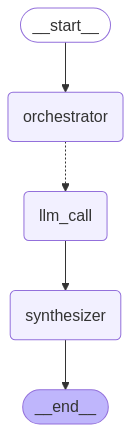

In [71]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))



In [72]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Introduction', description='This section will introduce the concept of Agentic AI and its relevance to RAGs.'), Section(name='What are RAGs?', description='This section will define RAGs and how they relate to Agentic AI.')]


**Introduction and Description**
===============

Agentic AI refers to artificial intelligence that demonstrate agency, which is the capacity to make decisions and act upon them in a given environment. This concept is particularly relevant to RAGs (Research Administration Groups) as they are responsible for managing and overseeing research projects that increasingly rely on AI systems, and data analytics. The integration of AI in research projects has the potential to revolutionize the way RAGs operate, making them more efficient, effective, and innovative. However, it also raises new challenges and concerns that need to be addressed. This report aims to explore the implications of Agentic AI on RAGs, its benefits, and challenges, and provide recommendations for its successful integration.

---

### What are RAGs?
RAGs (Reasoning-Action-Generation) are a type of Artificial General Intelligence (AGI) that enables the development of autonomous agents capable of performing complex tasks in dynamic environments. In the context of Agentic AI, RAGs serve as the core cognitive architecture, providing the necessary reasoning, decision-making, and action-generation capabilities for agents to interact with their environment, adapt to changes, and achieve their objectives.

RAGs consist of three primary components:

* **Reasoning**: The agent's ability to perceive its environment, interpret sensory data, and make informed decisions based on its knowledge, goals, and current situation.
* **Action-Generation**: The agent's capacity to translate its decisions into concrete actions that can be executed in the environment.
* **Feedback Loop**: The continuous cycle of sensing, reasoning, and feedback, which enables it to learn from its experiences, adapt to changes, and refine its decision-making processes over time.

By integrating these components, RAGs empower Agentic AI agents to exhibit intelligent behavior, such as problem-solving, planning, and learning, allowing them to operate effectively in complex, dynamic environments.